# Step 1: Data Acquisition
In order to measure article traffic from 2015-2022, you will need to collect data from the Pageviews API. The Pageviews API (documentation, endpoint) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through the previous complete month.

You will be collecting counts of pageviews using a specified subset of Wikipedia article pages. This is a subset of the English Wikipedia that represents a large number of dinosaur related articles.

You will use the same article subset to generate several related data sets. All of the data sets are time series of monthly activity. For all of the data sets we are only interested in actual user pageview requests. The three resulting datasets should be saved as a JSON files ordered using article titles as a key for the resulting time series data. You should store the time series data as returned from the API, with the exception of removing the ‘access’ field as it is misleading for mobile and cumulative files.

You will produce three files as follows:

1) Monthly mobile access - The API separates mobile access types into two separate requests, you will need to sum these to make one count for all mobile pageviews. You should store the mobile access data in a file called:
dino_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json
    
2) Monthly desktop access - Monthly desktop page traffic is based on one single request. You should store the desktop access data in a file called:
dino_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json

3) Monthly cumulative - Monthly cumulative data is the sum of all mobile, and all desktop traffic per article. You should store the monthly cumulative data in a file called:
dino_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json

For all of the files the <startYYYYMM> and <endYYYYMM> represent the starting and ending year and month as integer text.


## Configuring the API request endpoints


###  Importing the necessary packages


In [12]:
import json, time, urllib.parse
import re, requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime

### Configure the endpoint details

Endpoint details, headers and parameters are structured here. 
1423 distinct articles from the 'dinosaur_genera.cleaned.SEPT.2022' excel providded is utilitied for title extraction 

In [13]:
# For visualizing the dinosaur Wikipedia article titles 

df_raw = pd.read_excel('dinosaur_genera.cleaned.SEPT.2022.xlsx')
DINOSAUR_ARTICLES = df_raw['name'].unique()

In [16]:
# REST API 'pageviews' URL for common URL/endpoint for all 'pageviews' API requests

API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# To specify the type of pageviews request being made 
# This is a 'per-article' based request ( using format string to replace each parameter with a corresponding value before making the request

API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network to accomodate for the API calls limit of 100 requests per second
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# Including "unique ID" to the request for contact support from Wikimedia API if we were to run into errors

REQUEST_HEADERS = {
    'User-Agent': '<shubhacp@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# REST API parameters for the json data from the website
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # to be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start date provided
    "end":         "2022093000"    # end date provided
}

### For the REST API call to retrive the article related information

The functione execution first passes the header, parameters and endpoint details for the GET request. The REST API GET request is then triggered for each of the article and access type combination. Exceptions are recorded when data is not extracted from the endpoint

In [17]:
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # To ensure an article title
    if not article_title: return None
    
    # Replacing spaces in Titles with "_" and URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


## Extracting data of all dinosaur article names (all dinosaurs and all access types


### Extract the wikipedia article information for various access types (Desktop, Mobile, All)

Added exception handling to highlight the articles for which we couldn't pull the information using the API endpoint

In [22]:
access_type = [ 'desktop', 'mobile-app', 'mobile-web']
df_access = list()
for i in DINOSAUR_ARTICLES:
  # Exception handling to make sure code doesn't break
  try:
    for j in access_type:
      ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = j
      views = request_pageviews_per_article(article_title = i, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)
      df_access.append(pd.json_normalize(views['items']))
    #print("Obtained the pageview data for: ",i)
  except:
    print("Couldn't get the pageview data for: ",i)

# Obtain the overall dinosaurs data
dinosaur_raw = pd.concat(df_access)
dinosaur_raw.info()

Couldn't get the pageview data for:  “Coelosaurus” antiquus
<class 'pandas.core.frame.DataFrame'>
Int64Index: 337830 entries, 0 to 86
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   project      337830 non-null  object
 1   article      337830 non-null  object
 2   granularity  337830 non-null  object
 3   timestamp    337830 non-null  object
 4   access       337830 non-null  object
 5   agent        337830 non-null  object
 6   views        337830 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 20.6+ MB


## Loading JSON data into respective files based on access type


### Function to write the JSON data for each access type

In [23]:
def json_output(data = dinosaur_raw, access_name = 'desktop'):
  #data = data.drop('level_0', axis = 1)
  if access_name == 'mobile' or access_name == 'cumulative':
    columns = data.columns.to_list()
    columns.remove('views')
    data = data.groupby(columns).agg({'views': np.sum}).reset_index()

  if access_name == 'cumulative':
    data = data.groupby(columns).sum().groupby('article').cumsum().reset_index()

  data = data.sort_values(by = ['article', 'timestamp'], ascending = True)
  result = data.to_json(orient='records')[1:-1].replace('},{', '} {')
  result = '['+result+']'
  result = re.sub("}\s{", "},{", result)
  parsed = json.loads(result)
  json_object = json.dumps(parsed, indent=4)
  path = f'''dino_monthly_{access_name}_201507-202209.json'''
  with open(path, 'w') as f:
      f.write(json_object)

### To segregate the data into different files based on the access type



In [24]:
#Passing the data and segregate into different JSON files

data = dinosaur_raw
data.reset_index(inplace=True)

json_output(data[data['access']=='desktop'].drop(['access', 'index'], axis = 1), 'desktop')
json_output(data[(data['access']=='mobile-app') | (data['access'] == 'mobile-web')].drop(['access', 'index'], axis = 1), 'mobile')
json_output(data.drop(['access', 'index'], axis = 1), 'cumulative')

# Step 2 : Analysis
You will conduct a very basic visual analysis. The analysis for this homework is to graph specific subsets of the data as a timeseries. You will produce three different graphs.

## For Plot 1- Maximum Average and Minimum Average 
The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

### Reading the JSON files obtained from Step 1



In [25]:
# Reading the input json files for mobile and desktop access types and load the data into dataframes for further transformation

desktop = open('dino_monthly_desktop_201507-202209.json')
mobile = open('dino_monthly_mobile_201507-202209.json')

json_desktop = json.load(desktop)
json_mobile = json.load(mobile)

df_desktop = pd.json_normalize(json_desktop)
df_mobile = pd.json_normalize(json_mobile)

### To pull data from articles that have the highest and lowest average page requests over all months

The functions first calculates the average article views for all available months and pulls the article names with the highest and lowest average views and finally returns the data the articles obtained in the previous step


In [26]:
def add_labels(max, min, access = None):
  max['category'] = 'max_' + access
  max['label'] = max['category'] + '[' + max['article'] + ']'
  min['category'] = 'min_' + access
  min['label'] = min['category'] + '[' + min['article'] + ']'
  data = max.append(min)
  return data

def find_maxmin(data = None, access = 'desktop'):
  grouped = data.groupby("article").mean('views')
  data['timestamp'] = data['timestamp'].astype('str')
  data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y%m%d%H')
  max_name = grouped.loc[grouped['views'].idxmax()].name
  min_name = grouped.loc[grouped['views'].idxmin()].name
  data_max = data[data['article'] == max_name][['article', 'timestamp', 'views']]
  data_min = data[data['article'] == min_name][['article', 'timestamp', 'views']]
  data = add_labels(data_max, data_min, access)
  return data

def main_maxmin(desktop, mobile):
  desktop = find_maxmin(desktop, access = 'desktop')
  mobile = find_maxmin(mobile, access = 'mobile')
  df = desktop.append(mobile)
  df = df.set_index('timestamp')
  return df

df_main = main_maxmin(df_desktop, df_mobile)

### Plotting the data for the articles with highest and lowest average page views for both desktop and mobile


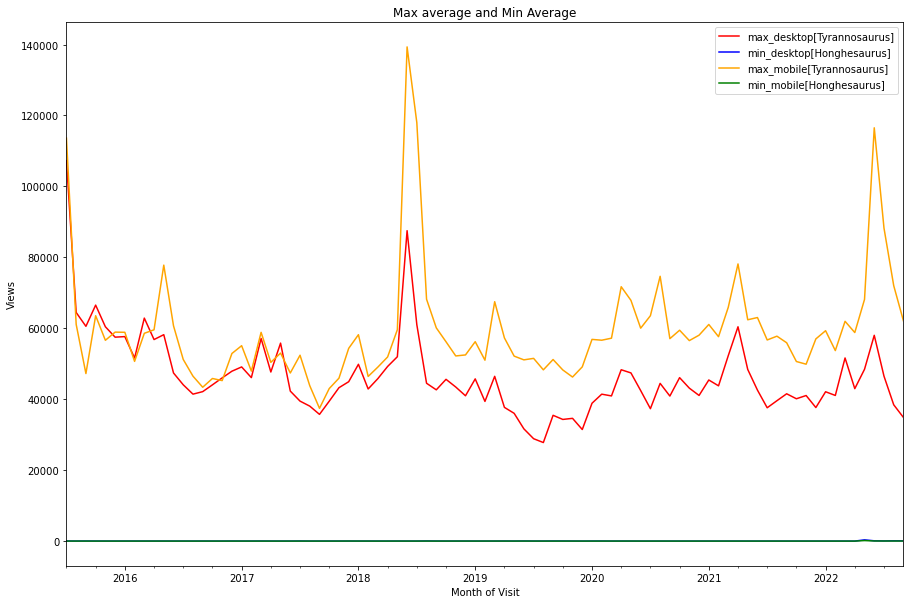

In [30]:


# Four time series plots in a single visual for comparison - two for each access type
def plot_maxmin(data):
  plt.figure(figsize=(15, 10))
  df1 = df_main[df_main['category'] == 'max_desktop']
  df1['views'].plot(label=df1['label'].unique()[0], color='red')
  df2 = df_main[df_main['category'] == 'min_desktop']
  df2['views'].plot(label=df2['label'].unique()[0], color='blue')
  df3 = df_main[df_main['category'] == 'max_mobile']
  df3['views'].plot(label=df3['label'].unique()[0], color='orange')
  df4 = df_main[df_main['category'] == 'min_mobile']
  df4['views'].plot(label=df4['label'].unique()[0], color='green')

  plt.title('Max average and Min Average')
  plt.xlabel('Month of Visit')
  plt.ylabel('Views')
  plt.legend()

  # Save the plot as a png file
  plt.savefig('article_maxmin_avg_views_plot1.jpg')

plot_maxmin(df_main)

## For Plot 2 - Top 10 Peak Page Views
The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

### To pull the articles list that have the top 10 page views over all months

The functions first calculates the maximum views across all the months for each article and pulls the top 10 articles with the highest page views and assigns them a rank based on the peak views value and finally returns the data for the acquired articles


In [31]:
def add_labels(df, access = None):
  df['category'] = df['article'] +'_' + access + '_top_' + df['rank'].astype('str')
  return df

def ten_largest(data = None, access = 'desktop'):
  grouped = data.groupby("article").max('views').reset_index()
  grouped = grouped.sort_values(by='views', ascending=False)
  top10 = grouped.head(10)
  top10 = top10[['article']].reset_index()
  top10 = top10.drop('index', axis = 1)
  top10['rank'] = pd.Series(np.arange(1,11))
  data['access'] = access
  data = data[['article', 'timestamp', 'views', 'access']]
  data = data.merge(top10, on='article', how = 'inner', suffixes=('_1', '_2'))
  data = add_labels(data, access)
  return data

def main_ten_largest(desktop, mobile):
  desktop = ten_largest(desktop, access = 'desktop')
  mobile = ten_largest(mobile, access = 'mobile')
  df = desktop.append(mobile)
  df = df.set_index('timestamp')
  return df

df_main = main_ten_largest(df_desktop, df_mobile)

### Plotting the data for the top 10 articles with highest page views for both desktop and mobile


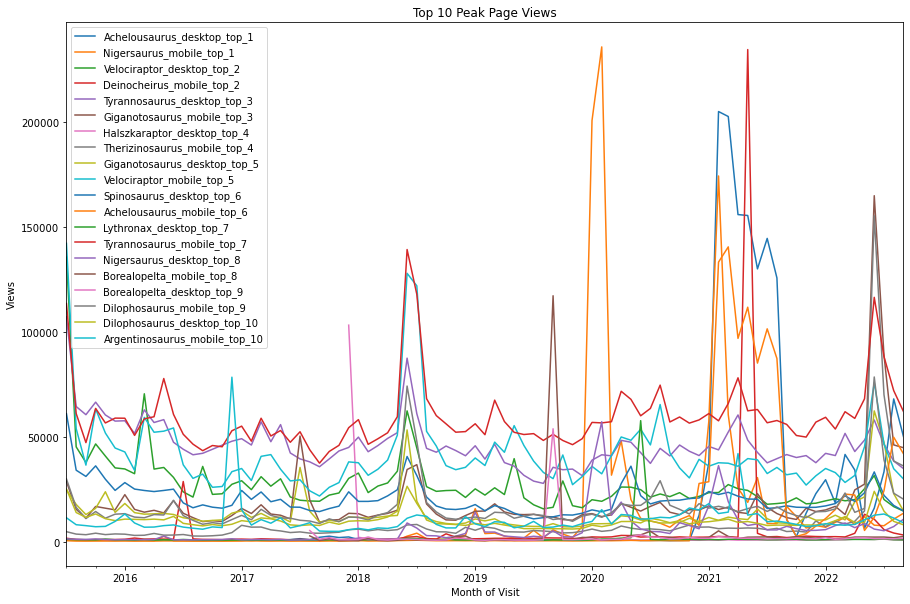

In [33]:
# Twenty time series plots in a single visual for comparison - ten for each access type

def plot_tenlargest(data):
  plt.figure(figsize=(15, 10))
  for i in range(1,11):
    df = data[data['rank'] == i]
    df[df['access'] == 'desktop']['views'].plot(label=df['category'].unique()[0])
    df[df['access'] == 'mobile']['views'].plot(label=df['category'].unique()[1])

  # adding title to the plot
  plt.title('Top 10 Peak Page Views')
  plt.xlabel('Month of Visit')
  plt.ylabel('Views')
  plt.legend()

  # Save the plot as a png file
  plt.savefig('article_peak_page_views_plot2.jpg')

plot_tenlargest(df_main)

## For Plot 3- Fewest Months of Data
The third graph should show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.



### To pull the articles with fewest months of available data

The functions first calculate the available data month count for every article and pull 10 articles with the fewest months of data available for them and finally return the data for those 10 articles acquired


In [34]:
def add_labels(df, access = None):
  df['category'] = df['article'] +'_' + access + '_least_freq_' + df['rank'].astype('str')
  return df

def ten_fewest(data = None, access = 'desktop'):
  grouped = data.groupby("article").count().reset_index().iloc[:,0:2]
  grouped = grouped.rename(columns={"project": "count"})
  grouped = grouped.sort_values(by='count', ascending=True)
  top10 = grouped.head(10)
  top10 = top10[['article']].reset_index()
  top10 = top10.drop('index', axis = 1)
  top10['rank'] = pd.Series(np.arange(1,11))
  data['access'] = access
  data = data[['article', 'timestamp', 'views', 'access']]
  data = data.merge(top10, on='article', how = 'inner', suffixes=('_1', '_2'))
  data = add_labels(data, access)
  return data

def main_fewest_months(desktop, mobile):
  desktop = ten_fewest(desktop, access = 'desktop')
  mobile = ten_fewest(mobile, access = 'mobile')
  df = desktop.append(mobile)
  df = df.set_index('timestamp')
  return df

df_main = main_fewest_months(df_desktop, df_mobile)

### Plotting the data for the articles with fewest months of available data

Please note, there are non continuous time plots for certain articles here due to lack of data availability for them during certain specific timestamps 


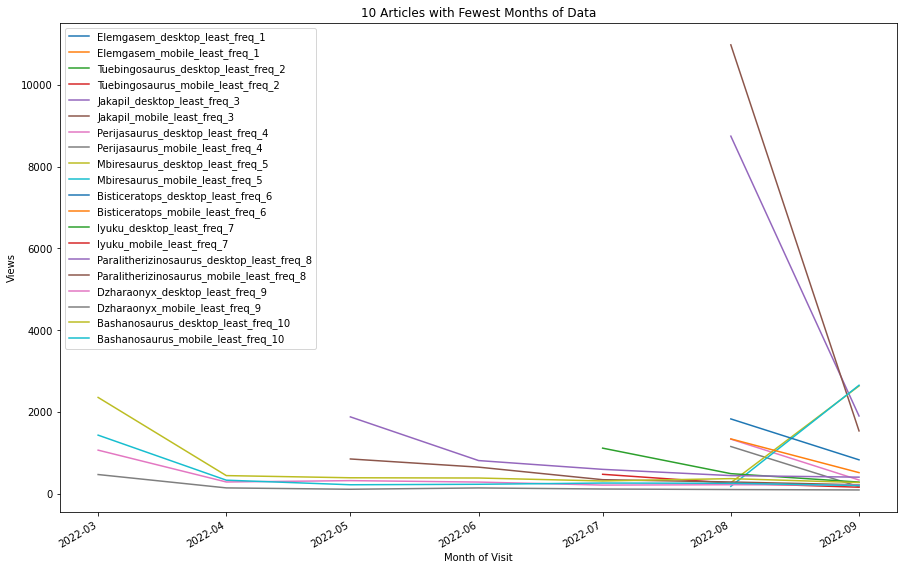

In [37]:
# Twenty time series plots in a single visual for comparison - ten for each access type

def plot_tenfewest(data):
  plt.figure(figsize=(15, 10))
  for i in range(1,11):
    df = data[data['rank'] == i]
    df[df['access'] == 'desktop']['views'].plot(label=df['category'].unique()[0])
    df[df['access'] == 'mobile']['views'].plot(label=df['category'].unique()[1])

  # adding title to the plot
  plt.title('10 Articles with Fewest Months of Data')
  plt.xlabel('Month of Visit')
  plt.ylabel('Views')
  plt.legend()

  # Save the plot as a png file
  plt.savefig('article_fewest_months_plot3.jpg')

plot_tenfewest(df_main)